In [7]:
%matplotlib inline
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

/opt/conda/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [8]:
# Do the necessary imports
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
from qiskit_textbook.tools import random_state, array_to_latex

In [9]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers

qr = QuantumRegister(3, name="q")    # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical bits
crx = ClassicalRegister(1, name="crx") # in 2 different registers
teleportation_circuit = QuantumCircuit(qr, crz, crx)

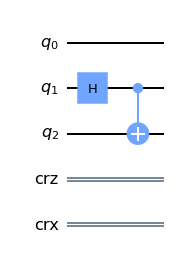

In [10]:
# Creating an entangled qubit pair
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) # Put qubit a into state |+> for X basis
    qc.cx(a,b) # CNOT with a as control and b as target

## Creating an entangled qubit pair
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
# In our case, Telamon entangles qubits q1 and q2
# Let's apply this to our circuit:
create_bell_pair(teleportation_circuit, 1, 2)
# And view the circuit so far:
teleportation_circuit.draw()

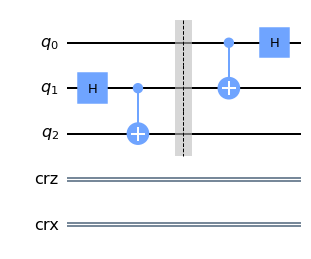

In [11]:
#Alice applies CNOT on q1 controlled by the state q0, alice applies H-gate on q0
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)
teleportation_circuit.draw()

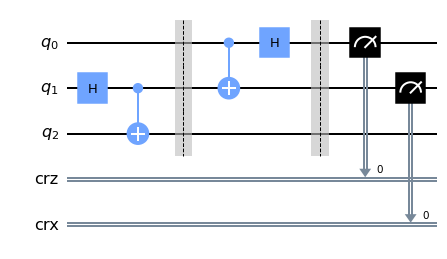

In [12]:
#Alice measures the state of her qubits and stores the results
# classical bits and shares them with Bob via classical channel
def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)

## STEP 3
measure_and_send(teleportation_circuit, 0 ,1)
teleportation_circuit.draw()

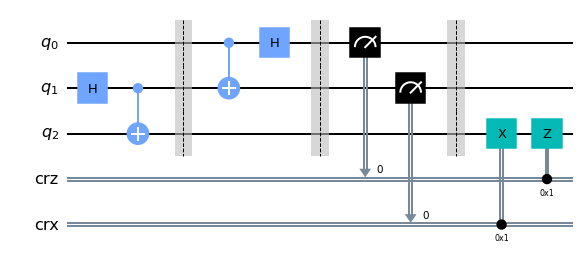

In [13]:
# based on Alice's classical bits states decides the gate
# QuantumCircuit (qc), integer (qubit) ClassicalRegisters (crz & crx)
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
    qc.z(qubit).c_if(crz, 1) # are in the state '1'
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() 
# Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)

## STEP 3
measure_and_send(teleportation_circuit, 0, 1)

## STEP 4
teleportation_circuit.barrier() 
# Use barrier to separate steps
bob_gates(teleportation_circuit, 2, crz, crx)
teleportation_circuit.draw()

<IPython.core.display.Math object>

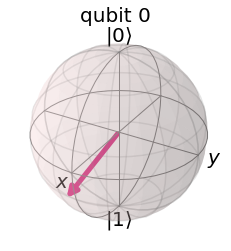

In [17]:
# Create random 1-qubit state q0
psi = random_state(1)

# Display it nicely
array_to_latex(psi, pretext="|\\psi\\rangle =")
# Show it on a Bloch sphere
plot_bloch_multivector(psi)

In [18]:
# Initialize q0 to state 0
init_gate = Initialize(psi)
init_gate.label = "init"

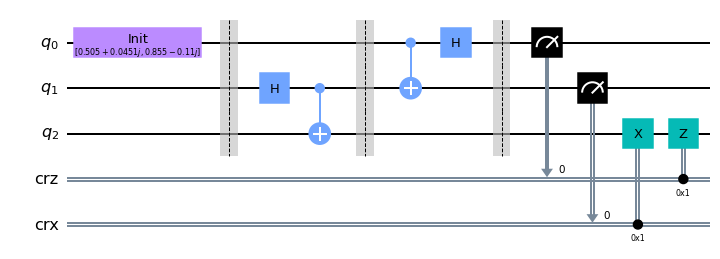

In [19]:
## SETUP
qr = QuantumRegister(3, name="q")   
# Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") 
# and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

# Display the circuit
qc.draw()

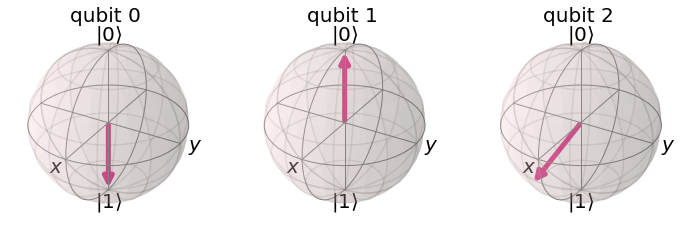

In [20]:
sv_sim = Aer.get_backend('statevector_simulator')
qobj = assemble(qc)
out_vector = sv_sim.run(qobj).result().get_statevector()
plot_bloch_multivector(out_vector)

In [21]:
inverse_init_gate = init_gate.gates_to_uncompute()

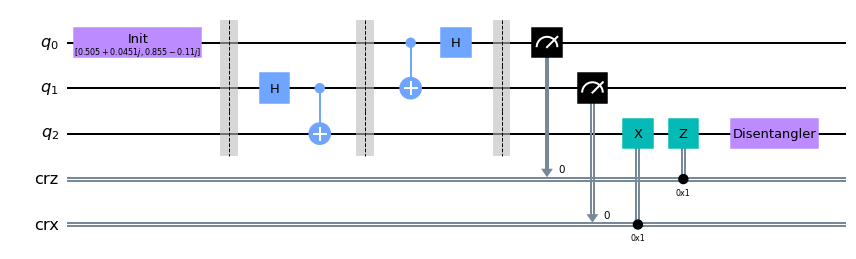

In [22]:
## SETUP
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

## STEP 5
# reverse the initialization process
qc.append(inverse_init_gate, [2])

# Display the circuit
qc.draw()

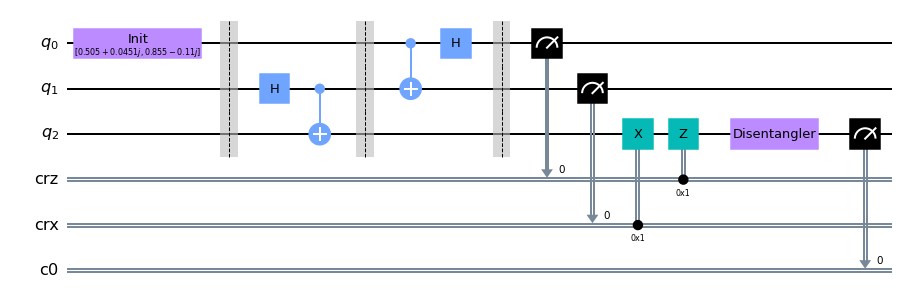

In [23]:
# Need to add a new ClassicalRegister
# to see the result
cr_result = ClassicalRegister(1)
qc.add_register(cr_result)
qc.measure(2,2)
qc.draw()

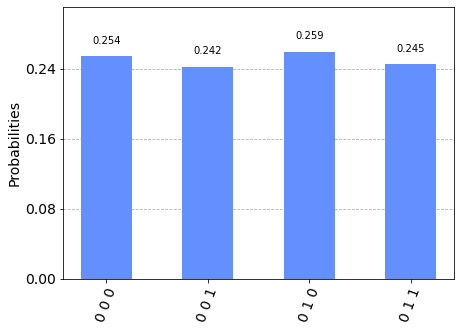

In [25]:
qasm_sim = Aer.get_backend('qasm_simulator')
t_qc = transpile(qc, qasm_sim)
qobj = assemble(t_qc)
counts = qasm_sim.run(qobj).result().get_counts()
plot_histogram(counts)

In [26]:
def new_bob_gates(qc, a, b, c):
    qc.cx(b, c)
    qc.cz(a, c)

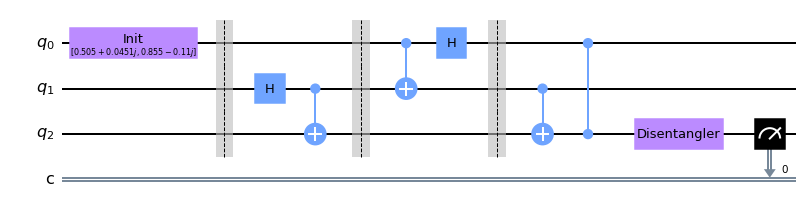

In [27]:
qc = QuantumCircuit(3,1)

# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)
qc.barrier()
# Alice sends classical bits to Bob
new_bob_gates(qc, 0, 1, 2)

# We undo the initialization process
qc.append(inverse_init_gate, [2])

# See the results, we only care about the state of qubit 2
qc.measure(2,0)

# View the results:
qc.draw()

In [28]:
# First, see what devices we are allowed to use by loading our saved accounts
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

/opt/conda/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2021-02-25 09:15:08,193: Credentials are already in use. The existing account in the session will be replaced.


In [ ]:
# get the least-busy backend at IBM and run the quantum circuit there
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))
t_qc = transpile(qc, backend, optimization_level=3)
qobj = assemble(t_qc)
job = backend.run(qobj)
job_monitor(job)  # displays job status under cell

Job Status: job is queued (15)    

In [ ]:
# Get the results and display them
exp_result = job.result()
exp_counts = exp_result.get_counts(qc)
print(exp_counts)
plot_histogram(exp_counts)